In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import atlite
import numpy as np
import logging 
logging.basicConfig(level=logging.INFO)
import xesmf as xe

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [2]:
from regridding_functions import read_and_average_era5_4y
from regridding_functions import read_and_average_sarah
from regridding_functions import regrid
rsds_era5_mean_4y= read_and_average_era5_4y('influx_direct')
rsds_sarah_mean= read_and_average_sarah('influx_direct')
rsds_era5_mean_cut=rsds_era5_mean_4y.sel(x=slice(-12, 35), y=slice(33, 64.8))
rsds_sarah_mean_cut=rsds_sarah_mean.sel(x=slice(-12, 35), y=slice(33, 64.8))
regridder=regrid(rsds_era5_mean_cut, rsds_sarah_mean_cut, method='conservative')  #regrid era5 (0.25x0.25) to the sarah grid (0.3x0.3)

['/groups/EXTREMES/cutouts/europe-1996-era5.nc', '/groups/EXTREMES/cutouts/europe-2010-era5.nc', '/groups/EXTREMES/cutouts/europe-2012-era5.nc', '/groups/EXTREMES/cutouts/europe-2010-era5.nc']
['/groups/EXTREMES/SARAH-3/europe-1996-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2010-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2012-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2010-sarah3-era5.nc']
189 190
128 129
157 158
107 108


In [3]:
rsds_era5_mean_interp_cut_4y=regridder(rsds_era5_mean_cut)
rsds_era5_mean_interp_cut_4y

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable influx_direct as the horizontal dimensions for the regridding.
  warnings.warn(


<xarray.DataArray (lat: 107, lon: 157)> Size: 67kB
dask.array<astype, shape=(107, 157), dtype=float32, chunksize=(107, 157), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 856B 33.0 33.3 33.6 33.9 34.2 ... 63.9 64.2 64.5 64.8
  * lon      (lon) float64 1kB -12.0 -11.7 -11.4 -11.1 ... 33.9 34.2 34.5 34.8
Attributes:
    regrid_method:  conservative

In [18]:
# Assuming these variables exist
denominator_era5_sarah= rsds_era5_mean_interp_cut_4y.values  # ERA5 dataset
numerator_era5_sarah= rsds_sarah_mean_cut.values  # SARAH dataset

# Ensure valid bias factor calculation
mask_valid = (denominator_era5_sarah != 0)  # Avoid division by zero and all values in sarah that have mean 0
bias_factor_era5_sarah = np.where(mask_valid, numerator_era5_sarah / denominator_era5_sarah, np.nan)  # Replace invalid cases with NaN

Longitude range: -12.0 to 35.0
Latitude range: 33.0 to 72.0


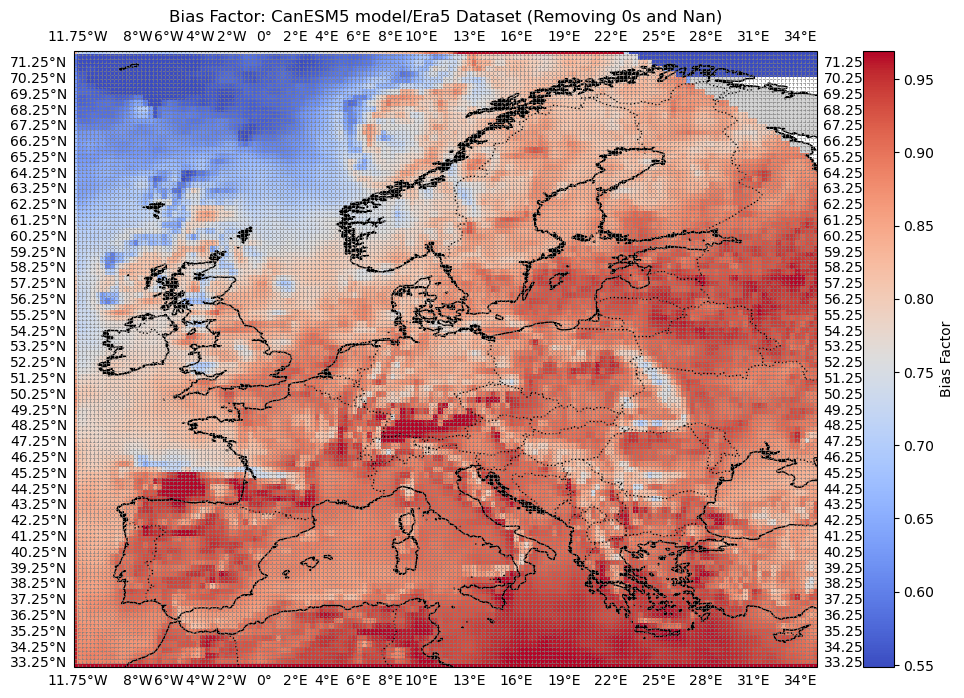

In [48]:
# Check if the biased_values shape matches lon2d, lat2d
# Get lat/lon values
lon = rsds_era5_mean_4y.lon.values 
lat = rsds_era5_mean_4y.lat.values

lon_era5=rsds_era5_mean_cut.lon.values
lat_era5=rsds_era5_mean_cut.lat.values

# Ensure lon/lat are 2D using meshgrid
# Ensure lon/lat are 2D using meshgrid
lon_edges = np.linspace(lon.min(), lon.max(), bias_factor_era5_sarah.shape[1] )
lat_edges = np.linspace(lat.min(), lat.max(), bias_factor_era5_sarah.shape[0] )
lon2d, lat2d = np.meshgrid(lon_edges, lat_edges)

# Use percentiles to remove outliers
vmin = np.nanpercentile(bias_factor_era5_sarah, 2)  # 2nd percentile (lower bound)
vmax = np.nanpercentile(bias_factor_era5_sarah, 98)  # 98th percentile (upper bound)

lon_min, lon_max = lon.min(), lon.max()
lat_min, lat_max = lat.min(), lat.max()
print(f"Longitude range: {lon_min} to {lon_max}")
print(f"Latitude range: {lat_min} to {lat_max}")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
# Set the exact extent to match the dataset boundaries
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot the bias factor (masked)
c = ax.pcolormesh(
    lon2d, lat2d, bias_factor_era5_sarah,  # Ensure correct shapes
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for bias factor
    shading='auto',
    vmin=vmin, vmax=vmax  # Clip extreme outliers
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.set_title("Bias Factor: CanESM5 model/Era5 Dataset (Removing 0s and Nan)")

# Add gridlines for each latitude and longitude
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--', xlocs=lon, ylocs=lat, x_inline=False, y_inline=False)

# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical', label='Bias Factor')

plt.show() 

In [27]:
numerator_era5_sarah.shape

(107, 157)

In [ ]:
#bias factor between era5 and sarah in a 0.3x0.3 grid
bias_factor_era5_sarah.shape 

(107, 157)

In [17]:
from regridding_functions import read_and_average_era5_marta
from regridding_functions import read_and_average_cmip
rsds_era5_mean_BOC= read_and_average_era5_marta('influx_direct') #mean of era5 historical period
rsds_model_mean_BOC= read_and_average_cmip('SFCRAD/CanESM5/historical/r1i1p2f1/', 'rsds') #mean of model of historical period

['/groups/EXTREMES/cutouts/europe-1980-era5.nc', '/groups/EXTREMES/cutouts/europe-1981-era5.nc', '/groups/EXTREMES/cutouts/europe-1982-era5.nc', '/groups/EXTREMES/cutouts/europe-1983-era5.nc', '/groups/EXTREMES/cutouts/europe-1984-era5.nc', '/groups/EXTREMES/cutouts/europe-1985-era5.nc', '/groups/EXTREMES/cutouts/europe-1986-era5.nc', '/groups/EXTREMES/cutouts/europe-1987-era5.nc', '/groups/EXTREMES/cutouts/europe-1988-era5.nc', '/groups/EXTREMES/cutouts/europe-1989-era5.nc', '/groups/EXTREMES/cutouts/europe-1990-era5.nc', '/groups/EXTREMES/cutouts/europe-1991-era5.nc', '/groups/EXTREMES/cutouts/europe-1992-era5.nc', '/groups/EXTREMES/cutouts/europe-1993-era5.nc', '/groups/EXTREMES/cutouts/europe-1994-era5.nc', '/groups/EXTREMES/cutouts/europe-1995-era5.nc', '/groups/EXTREMES/cutouts/europe-1996-era5.nc', '/groups/EXTREMES/cutouts/europe-1997-era5.nc', '/groups/EXTREMES/cutouts/europe-1998-era5.nc', '/groups/EXTREMES/cutouts/europe-1999-era5.nc', '/groups/EXTREMES/cutouts/europe-2000-e

In [20]:
rsds_era5_mean_BOC=rsds_era5_mean_BOC.sel(x=slice(-12, 35), y=slice(33, 64.8))
rsds_model_mean_BOC=rsds_model_mean_BOC.sel(lon=slice(-12, 35), lat=slice(33, 64.8))

In [21]:
ds_03=xr.open_dataset('europe_03.nc') #grid 0.3x0.3 

In [32]:
from regridding_functions import regrid
regridder_era5=regrid(rsds_era5_mean_BOC, ds_03, method='conservative') #regrid era5 to the 0.3x0.3º grid to be able to apply bias factor 
rsds_era5_03=regridder_era5(rsds_era5_mean_BOC)
rsds_era5_03.sel(lon=slice(-12, 35), lat=slice(33, 64.8))
#bias_factor_era5_sarah.shape
rsds_era5_03
rsds_era5_correct=rsds_era5_03.sel(lon=slice(-12, 35), lat=slice(33, 64.8))*bias_factor_era5_sarah #apply bias factor to era5 rsds
rsds_era5_correct

189 190
128 129
157 158
131 132


/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable influx_direct as the horizontal dimensions for the regridding.
  warnings.warn(


<xarray.DataArray (lat: 107, lon: 157)> Size: 67kB
dask.array<mul, shape=(107, 157), dtype=float32, chunksize=(107, 157), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 856B 33.0 33.3 33.6 33.9 34.2 ... 63.9 64.2 64.5 64.8
  * lon      (lon) float64 1kB -12.0 -11.7 -11.4 -11.1 ... 33.9 34.2 34.5 34.8

In [35]:
regridder_era503_model=regrid(rsds_era5_correct, rsds_model_mean_BOC, method='conservative') #regrid corrected era5 to the model grid, conservative method because upscaling
rsds_era5_correct_model=regridder_era503_model(rsds_era5_correct) #regrid corrected era5 to the model grid
rsds_era5_correct_model=rsds_era5_correct_model.sel(lon=slice(-12, 35), lat=slice(33, 64.8))
#rsds_era5_correct_model is the corrected era5 dataset in the model grid
rsds_era5_correct_model

157 158
107 108
17 18
11 12


/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable None as the horizontal dimensions for the regridding.
  warnings.warn(


<xarray.DataArray (lat: 11, lon: 17)> Size: 748B
dask.array<astype, shape=(11, 17), dtype=float32, chunksize=(11, 17), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 44B 34.88 37.67 40.46 43.25 ... 57.21 60.0 62.79
  * lon      (lon) float32 68B -11.25 -8.438 -5.625 -2.812 ... 28.12 30.94 33.75
Attributes:
    regrid_method:  conservative

In [38]:
def check_lat_lon_range_and_increment(ds, dataset_name):
    # Extract the latitude and longitude
    lat = ds.lat
    lon = ds.lon
    
    # Latitude and longitude range
    lat_range = (lat.min().values, lat.max().values)
    lon_range = (lon.min().values, lon.max().values)
    
    # Latitude and longitude increment (difference between consecutive values)
    lat_increment = np.abs(lat[1] - lat[0]).values
    lon_increment = np.abs(lon[1] - lon[0]).values
    
    print(f"Dataset: {dataset_name}")
    print(f"Latitude range: {lat_range}")
    print(f"Longitude range: {lon_range}")
    print(f"Latitude increment: {lat_increment} degrees")
    print(f"Longitude increment: {lon_increment} degrees")
    print("-" * 50)

# Check for rsds_era5_mean_cut
check_lat_lon_range_and_increment(rsds_era5_correct_model, "rsds_era5_correct model")

# Check for rsds_era5_mean_interp_cut
check_lat_lon_range_and_increment(rsds_model_mean_BOC, "rsds_model_mean_interp_cut")
check_lat_lon_range_and_increment(rsds_era5_03, "rsds_era5_0.3x0.3")

Dataset: rsds_era5_correct model
Latitude range: (array(34.88252258), array(62.78735352))
Longitude range: (array(-11.25), array(33.75))
Latitude increment: 2.7905654907226562 degrees
Longitude increment: 2.8125 degrees
--------------------------------------------------
Dataset: rsds_model_mean_interp_cut
Latitude range: (array(34.88252258), array(62.78735352))
Longitude range: (array(-11.25), array(33.75))
Latitude increment: 2.7905654907226562 degrees
Longitude increment: 2.8125 degrees
--------------------------------------------------
Dataset: rsds_era5_0.3x0.3
Latitude range: (array(33.), array(72.))
Longitude range: (array(-12.), array(34.8))
Latitude increment: 0.29999999999999716 degrees
Longitude increment: 0.3000000000000007 degrees
--------------------------------------------------


In [40]:
numerator_era5_model=rsds_era5_correct_model.values
denominator_era5_model=rsds_model_mean_BOC.values
# Ensure valid bias factor calculation
mask_valid_2 = (denominator_era5_model != 0) & (numerator_era5_model != 0)  # Avoid division by zero and all values in SARAH that have mean 0
bias_factor_era5_model = np.where(mask_valid_2, numerator_era5_model / denominator_era5_model, np.nan)  # Replace invalid cases with NaN
bias_factor_era5_sarah

array([[1.0454338 , 0.96262056, 0.96645945, ..., 0.9977398 , 0.99822104,
        1.0055963 ],
       [0.95644873, 0.8792847 , 0.8825338 , ..., 0.91174465, 0.911982  ,
        0.9159733 ],
       [0.95877975, 0.8793321 , 0.8834796 , ..., 0.90792257, 0.910746  ,
        0.91893435],
       ...,
       [0.5869599 , 0.53217655, 0.53825295, ..., 0.        , 0.        ,
        0.        ],
       [0.6013248 , 0.5414682 , 0.5373324 , ..., 0.        , 0.        ,
        0.        ],
       [0.82173234, 0.734761  , 0.7163955 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [ ]:
#comparison between model BoC without and with the bias factor
